In [2]:
# 本コードは神山・鈴木(産総研)作のコードをベースに一部変更・改良したもの。
# This code is based on the code written by Kouyama and Suzuki (AIST) and its modification.

In [3]:
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
import struct
%matplotlib inline

In [4]:
def readXYZ(fname,model_us,model_vs,n_len):
    array=np.zeros((7,768,1024))
    nn=7*1024*768
    f=open(fname,"rb")
    Datas=f.read(nn*4)
    f.close
    unpack_data=(struct.unpack('<{}f'.format(nn),Datas))
#    print(array.shape)
    pp=0
    i=0
    for kk in range(7):
        for ii in range(768):
            for jj in range(1024):
                array[kk,ii,jj]=unpack_data[pp]
                pp+=1
    xs=np.zeros(n_len)
    ys=np.zeros(n_len)
    zs=np.zeros(n_len)

    for ii in range(n_len):
        x0=int(model_us[ii])
        y0=int(model_vs[ii])
        #x0=int(u0*2)
        #y0=int(v0*1.5)
        dis=array[3,y0-1:y0+2,x0-1:x0+2]
        dis_max=np.unravel_index(np.argmax(dis), dis.shape)
        #print(dis , dis_max) 
        shift=np.array(dis_max)-1
        y0+=shift[0]
        x0+=shift[1]
        xs[ii]=array[0,y0,x0]
        ys[ii]=array[1,y0,x0]
        zs[ii]=array[2,y0,x0]
        if array[3,y0,x0] != 0.:
            array[4,y0-5:y0+5,x0-5:x0+5]=1000
            
    im=np.stack([array[6],array[5],array[4]],axis=2)/4.
    
    imgplot = plt.imshow(im)
    cv2.imwrite('test.png',im)
    #cv2.imwrite(fname.split('.')[0]+'.png',im)
    
    #print("kokokara")
    #print(fname.split('.')[0])
    return xs,ys,zs
#
# カメラの対応点探索結果からカメラ位置を求める
#

import numpy as np
import math
import cv2
## CSV ##
import pandas as pd
## Rotation
from scipy.spatial.transform import Rotation

def CalcPnP(n_len,im_x,im_y,xs,ys,zs,tmp_K, dist):
    # 回転テスト
    #theta = 15.*np.pi/180 # OpenCVの形式を意識
    #im_x = np.cos(theta)*(im_x - cx) - np.sin(theta)*(im_y - cy) + cx
    #im_y = np.sin(theta)*(im_x - cx) + np.cos(theta)*(im_y - cy) + cy
    im_vec = np.zeros((n_len,2), np.float64)
    im_vec[:,0] = im_x
    im_vec[:,1] = im_y

    # 各点の読み込み (left hand coordinate => right hand coordinate)
    gcp_x = np.array(xs,dtype='float64')
    gcp_y = -np.array(ys,dtype='float64') ## Y軸を反転させる
    gcp_z = np.array(zs,dtype='float64')

    X_earth = np.zeros((n_len,3), np.float64)
    X_earth_ground = np.zeros((n_len,3), np.float64)

    X_earth[:,0] = gcp_x
    X_earth[:,1] = gcp_y
    X_earth[:,2] = gcp_z

    # 平均位置を調べる
    im_x_mean = np.mean(im_x)
    im_y_mean = np.mean(im_y)

    gcp_x_mean = np.mean(gcp_x)
    gcp_y_mean = np.mean(gcp_y)
    gcp_z_mean = np.mean(gcp_z)

    X_earth_mean = np.zeros((3), np.float64)
    X_earth_mean_ground = np.zeros((3), np.float64)
    X_earth_mean[0] = gcp_x_mean
    X_earth_mean[1] = gcp_y_mean
    X_earth_mean[2] = gcp_z_mean

    #print('Number of measured points: ', n_len)
    #print('Mean position in image: ')
    #print(' ', im_x_mean, im_y_mean)

    print('Mean position in world coordinate: ')
    print(' ', gcp_x_mean, gcp_y_mean, gcp_z_mean)

    #
    # solve PNP
    #
    # 結果をわかりやすくするため + 計算の安定のため原点をサンプルの平均位置にする
    X_earth -= X_earth_mean
    
    
    ret, rvec, tvec = cv2.solvePnP(X_earth, im_vec, tmp_K, dist, flags = cv2.SOLVEPNP_ITERATIVE)
    #ret, rvec, tvec,inliers = cv2.solvePnPRansac(X_earth, im_vec, tmp_K, dist)
    #rvec, tvec =cv2.solvePnPRefineVVS(X_earth, im_vec, tmp_K, dist, rvec, tvec)

    # Reprojection Error
    imgpts, jac = cv2.projectPoints(X_earth, rvec, tvec, tmp_K, dist)
    #print("im_vec         imgpts" )
    #print( im_vec,  imgpts)
    #print( im_vec , imgpts)
    np.save("./test_imgpts" , imgpts)
    RE = np.abs(imgpts[:,0] - im_vec)

    #np.save("./re_mse" ,RE.mean())
    #df = pd.read_csv("3412_2.csv")
    #df["mse"] = 0.0
    #for i , v in enumerate(RE):
     #   df["mse"][i] = np.mean(RE[i])
    #df.to_csv("mse.csv")
    #RE = RE[RE.max(1) < threshold]
    #test = np.where[RE[:,0] <10]
    print("Reprojection error mean stddev:")
    print(np.mean(RE),np.std(imgpts[:,0]-im_vec))
    #print("max pixel : " , np.max(np.abs(imgpts[:,0]-im_vec)) , np.argmax(np.abs(imgpts[:,0]-im_vec)))
    #print(len(RE))
    #print(np.abs(imgpts[:,0]-im_vec))
    # Rotation matrix from Rotatin vector
    # PnPsolver provides World (local) to Camera rotation matrix
    rotM = cv2.Rodrigues(rvec)[0]

    # inverse Rotaion matrix
    # Camera to world
    i_rotM = np.linalg.inv(rotM)
    i_rvec = cv2.Rodrigues(i_rotM)[0]

    # for debug
    tf = ret

    # Rotvec to Euler
    rotR = Rotation.from_rotvec(i_rvec.reshape(3))
    rotE = rotR.as_euler('zxy',degrees=True)
    #rotE = rotR.as_euler('ZXY',degrees=True)

    #print('Rotation angle, Z->X->Y, in Righthand coordinate:')
    #print(rotE)

    ## Convert left hand rotation / assuming World & Local coordinate rotation
    ## The order of the vector rotE is same as the Rotation order (zxy)
    ## ThetaZ => -ThetaZ, ThetaX => -ThetaX, ThetaY => ThetaY
    l_rotE = np.zeros(3)
    l_rotE[0]= -rotE[0]
    l_rotE[1]= -rotE[1]
    l_rotE[2]= rotE[2] #+ 180

    print('Rotation angle in Unity interface:')
    print("[X, Y, Z]: " , l_rotE[1],l_rotE[2],l_rotE[0])
    ## 13.7, 152.9, 1.4
    
    # カメラ位置の地球の座標系での表現 (逆行列をかけて符号を逆にする操作で変換できる)
    r_tvec = -np.dot(i_rotM, tvec)
    camera_pos = r_tvec[:,0] + X_earth_mean

    #print('')
    print('camera pos in Earth coordinate in Righthand coordinate: ')
    print(' ', camera_pos[0], camera_pos[1], camera_pos[2])
    
#    print('rvec: ',rvec[:,0])
#    print('tvec: ',tvec[:,0]+ X_earth_mean)
def make_tmpmat(x_pix,y_pix,FOV):
        # カメラ配列, チェッカーパターンの解析から  行。列の順番に注意
    #fy=(y_pix/2.)*np.tan((90.-FOV/2.)*(np.pi/180.))/(y_pix/512.)
    #fx=fy*(float(y_pix)/float(x_pix))
    
    fy = (y_pix/2)*np.tan((90. - FOV/2.)*(np.pi/180.)) #FOV 画角
    fx = fy 
    cx = x_pix //2  #x_pix 画像の幅サイズ
    cy = y_pix //2  #y_pix 画像の縦サイズ
    
    tmp_K = np.zeros((3,3),np.float64)
    tmp_K[0,0]=fx
    tmp_K[1,1]=fy
    tmp_K[2,2]=1.0
    tmp_K[0,2]=cx
    tmp_K[1,2]=cy
    
    return tmp_K

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv("img_4044.csv")
#df = pd.read_csv("3412_2.csv")
len(df)

15

In [7]:
img_pixel = df["img_pixel"]
len(img_pixel)

15

In [8]:
img_x = np.array([])
img_y = np.array([])
flag = False
for s in img_pixel: 
    t = 5
    try :
        img_x = np.append(img_x , (int(s[1:t]) ))
        #img_x = np.append(img_x , (int(s[1:t]) *2 ))
    except:
        try:
            t  = 4
            img_x = np.append(img_x , (int(s[1:t])))
            #img_x = np.append(img_x , (int(s[1:t]) *2))
        except:
            flag = True
            t  = 3
            img_x = np.append(img_x , (int(s[1:t])))
            #img_x = np.append(img_x , (int(s[1:t]) *2 ))
    if flag:
        img_y = np.append(img_y , (int(s[t+2:-1])))
        #img_y = np.append(img_y , (int(s[t+2:-1]) *2))
    else:
        img_y = np.append(img_y , (int(s[t+1:-1])))
        #img_y = np.append(img_y , (int(s[t+1:-1]) *2))
img_x,img_y

(array([1068.,  768., 1427., 1461., 1679., 1750.,  521.,  224.,  592.,
         203., 1293.,  409., 1311., 1433., 1012.]),
 array([575., 412., 464., 514., 468., 516., 566., 507., 343., 628., 248.,
        323., 492., 242., 261.]))

In [9]:
model_pixel = df["model_pixel"]
#model_csv = pd.read_csv("/Users/xiaconghe/Desktop/AIST/test/model_3412_test.csv")
#model_pixel = model_csv["model_pixel"]
model_pixel

0     (504, 701)
1     (394, 592)
2     (718, 639)
3     (731, 674)
4     (858, 648)
5     (893, 684)
6     (222, 677)
7     (103, 636)
8     (336, 550)
9      (48, 708)
10    (706, 506)
11    (265, 532)
12    (657, 652)
13    (777, 506)
14    (568, 510)
Name: model_pixel, dtype: object

In [10]:
model_x = np.array([])
model_y = np.array([])
flag = False
for s in model_pixel: 
    t = 5
    try :
        model_x = np.append(model_x , (int(s[1:t])))
    except:
        try:
            t  = 4
            model_x = np.append(model_x , (int(s[1:t])))
        except:
            flag = True
            t =3 
            model_x = np.append(model_x , (int(s[1:t])))
            
    if flag:
        model_y = np.append(model_y , (int(s[t+2:-1])))
    else:
        model_y = np.append(model_y , (int(s[t+1:-1])))
    
print(len(model_x))
model_x , model_y

15


(array([504., 394., 718., 731., 858., 893., 222., 103., 336.,  48., 706.,
        265., 657., 777., 568.]),
 array([701., 592., 639., 674., 648., 684., 677., 636., 550., 708., 506.,
        532., 652., 506., 510.]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 : model FOV_model  56
 using points : 15
Mean position in world coordinate: 
  67.0186045328776 -24.2987543741862 165.81318054199218
Reprojection error mean stddev:
0.5265453928018625 0.6825011023061686
Rotation angle in Unity interface:
[X, Y, Z]:  0.08059738584148703 54.19721095909925 0.05992553289509904
camera pos in Earth coordinate in Righthand coordinate: 
  46.9879336426451 -30.9828495192433 152.475468795962
real 37.7
Mean position in world coordinate: 
  67.0186045328776 -24.2987543741862 165.81318054199218
Reprojection error mean stddev:
2.036655692590521 2.910775784501189
Rotation angle in Unity interface:
[X, Y, Z]:  18.96004338501666 60.78406594870529 -0.3937251387813193
camera pos in Earth coordinate in Righthand coordinate: 
  43.77578000999842 -30.571197857418433 154.31103528827677
done!


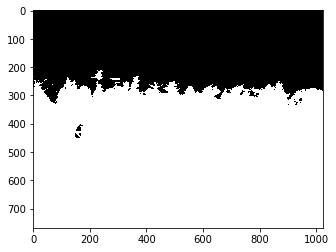

In [11]:
def main():
    #print('=== Input ===')
    #print('Camera array: ')
    #print(tmp_K)
    #print('Distortion parameters: ')
    #print(dist)
    #print('')
    # Distortion parameters, チェッカーパターンの解析から
#    dist =  np.array([ 0.25972578, -0.47507615,  0.00466432,  0.00113298, -0.06530443],dtype='float64')
    dist=np.zeros(5)

    #number='3412' 
    #6861_2 , FOV : model_ 60 , img_50 
    #6861_3 , FOV : model_58 , img_50 
    #6861_3 , FOV : model_58 , img_51 Ransac
#    number='6933'
#    mode='rank'  
    #mode='top_10'
    ## 対応点探索結果を読み込む
    #model_input = pd.read_csv('C:/work/PnP/result/result/'+number+'/correspondence_Bt_'+mode+'.txt', sep=",",header=None)
    
    #model_input = pd.read_csv('/Users/xiaconghe/Desktop/AIST/PnP_Code/model.txt', sep=",",header=None)
    n_len = len(model_x)
    #fname="/Users/xiaconghe/Desktop/AIST/Unity_images/"+number+"_model_7d.dat" 
    #fname="/Users/xiaconghe/Desktop/AIST/Unity_images/tukuba1_test.dat"
    fname="/Users/xiaconghe/Desktop/AIST/Unity_images/img_4044.dat"
    #fname="/Users/xiaconghe/Desktop/AIST/Unity_images/tsukuba_1_test.dat"
    FOV_model = 56
    tmp_K_m = make_tmpmat(1024,768,FOV_model)  #x_pix,y_pix,Field Of View [deg]
    
    FOV_real =  37.7

    tmp_K_r = make_tmpmat(1920 , 1080 , FOV_real)    

    xs,ys,zs = readXYZ(fname,model_x ,model_y ,n_len)


    n_len = len(xs)


    print(' : model FOV_model ' , FOV_model )
    print(" using points :" , len(model_x))
    CalcPnP(n_len,model_x,model_y, xs , ys , zs , tmp_K_m, dist )

    print('real' , FOV_real)
    CalcPnP(n_len , img_x , img_y , xs , ys , zs , tmp_K_r, dist )
        #CalcPnP(n_len,model_x,model_y, xs , ys , zs , tmp_K_m, dist )

if __name__=='__main__':
    main()
    print("done!")